# Imports COCO dataset

In [5]:
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io

# Imports MediaPipe

In [6]:
import scipy.io
import os
import mediapipe as mp
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import shutil

# Imports for boths

In [7]:
import numpy as np

# Load test images for model MediaPipe

In [22]:
N = 10
#MPII_IMAGES_DIR = "./mpii/images"
#COCO_IMAGES_DIR = "./coco/images/train2017"
#IMAGE_FILES = [os.path.join(MPII_IMAGES_DIR, file) for file in os.listdir(MPII_IMAGES_DIR) if file.endswith(('.jpg'))][:N]
#print(IMAGE_FILES)
MEDIAPIPE_IMAGES_DIR = "./MEDIAPIPE_images"
output_folder= "./extracted_images_coco"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load annotations from COCO dataset

In [10]:
dataDir = './coco/'
dataType = 'val2017'
annFile_kps = '{}/annotations/person_keypoints_{}.json'.format(dataDir, dataType)
coco_kps = COCO(annFile_kps)

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


# Get'person' category ID and get image ID with 'person' category

In [11]:
catIds = coco_kps.getCatIds(catNms=['person'])
imgIds = coco_kps.getImgIds(catIds=catIds)[:10]
#print(imgIds)

# Load and show the first 10 images with Keypoints

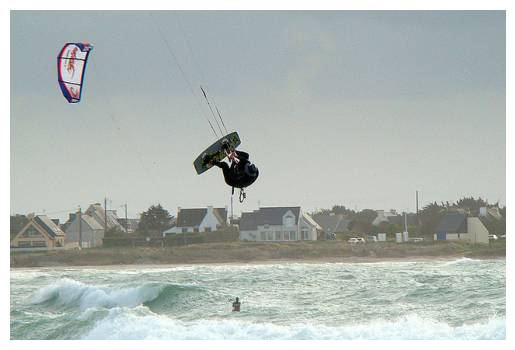

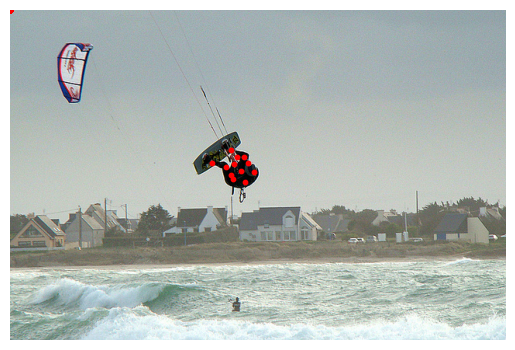

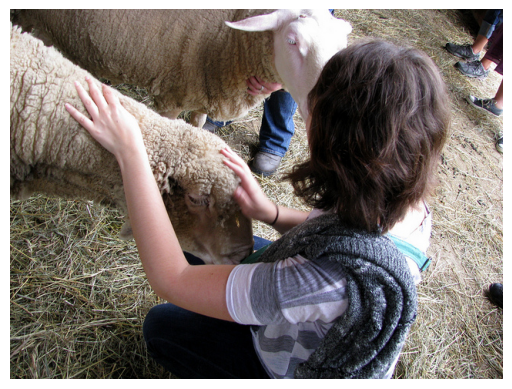

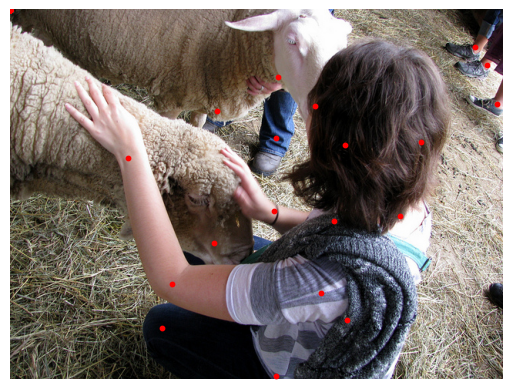

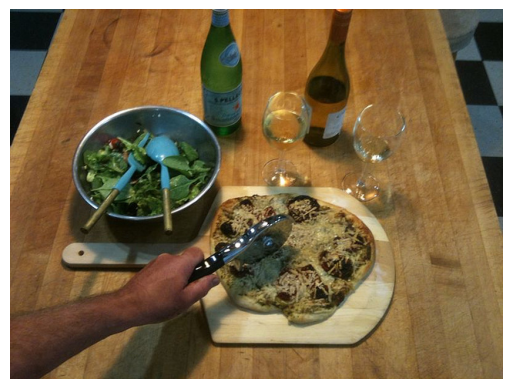

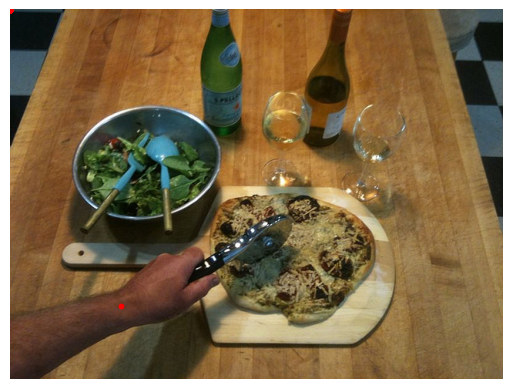

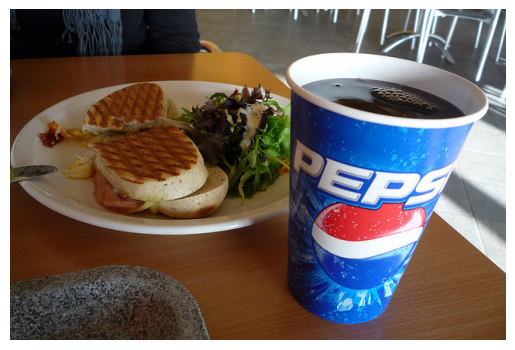

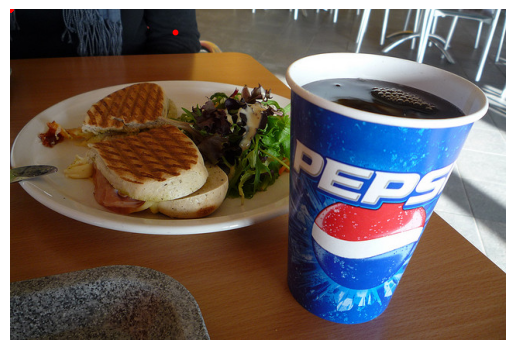

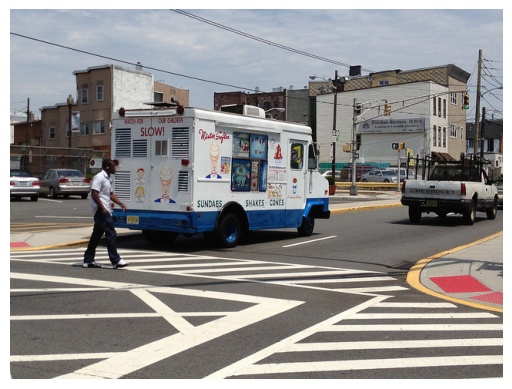

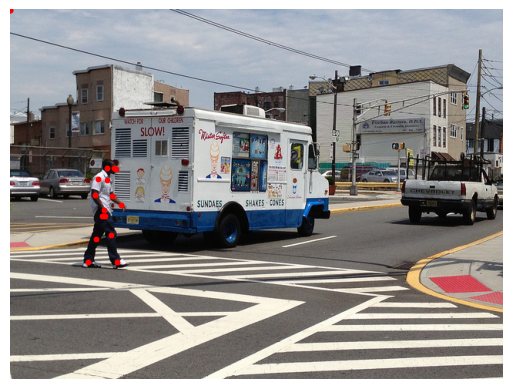

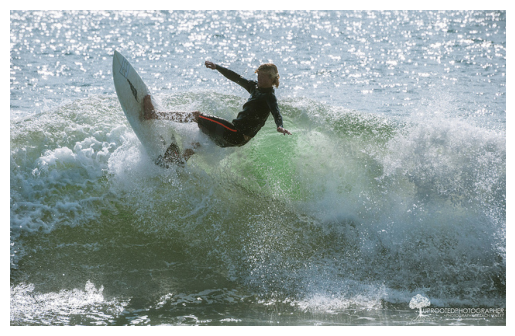

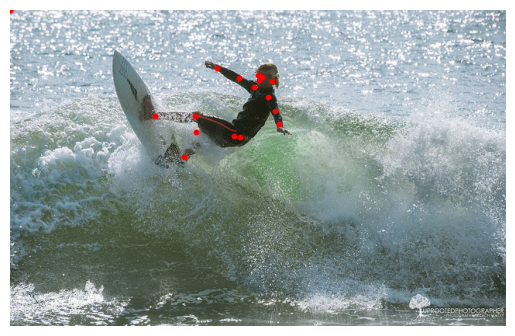

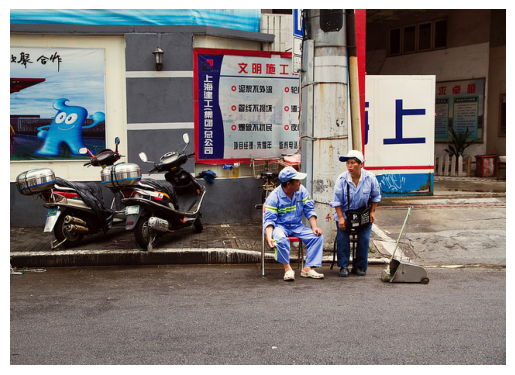

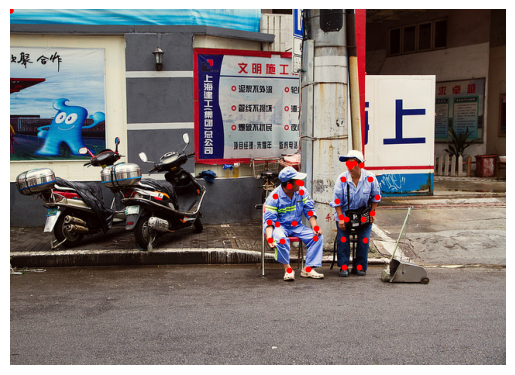

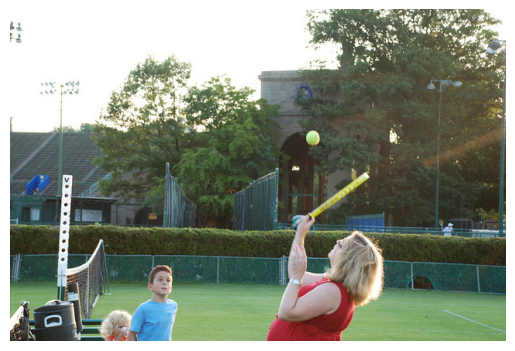

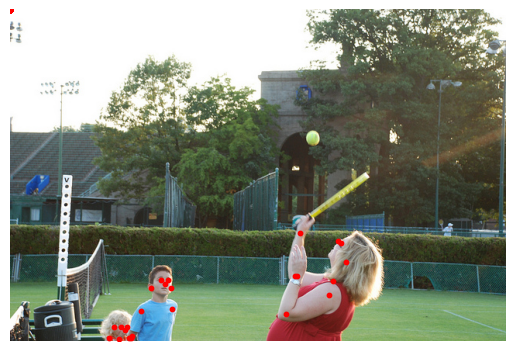

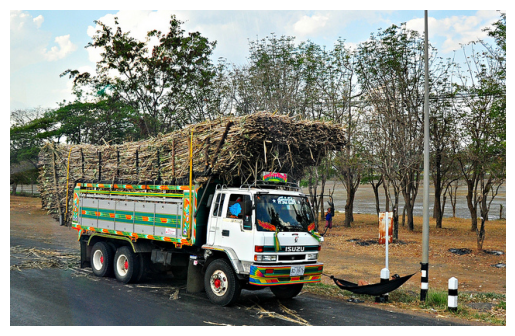

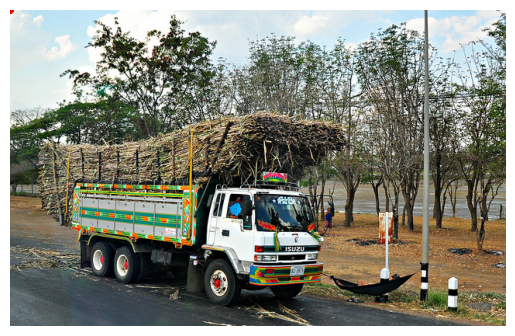

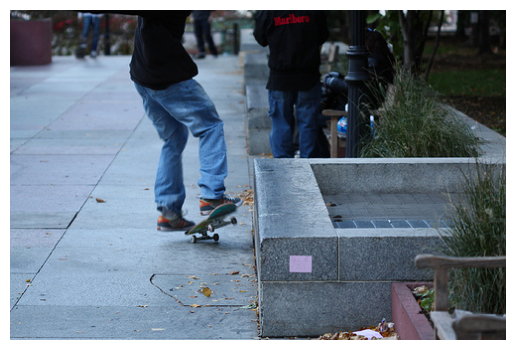

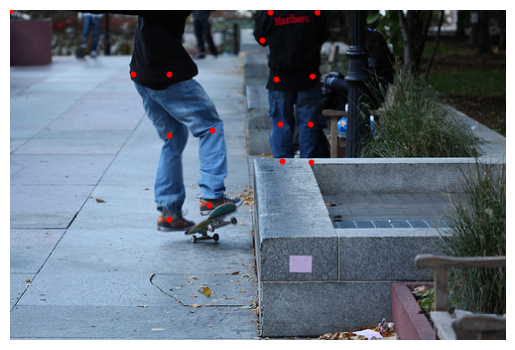

In [17]:
for imgId in imgIds:
    
    img_info = coco_kps.loadImgs(imgId)[0]
    img_url = img_info['coco_url']
    
    
    I = io.imread(img_url)
    filename = img_url.split('/')[-1]
    output_path = os.path.join(output_folder, filename)
    
    
    io.imsave(output_path, I)
    
    
    plt.imshow(I)
    plt.axis('off')
    plt.show()
    
    
    annIds = coco_kps.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    for ann in anns:
        keypoints = ann['keypoints']
        if keypoints:
            keypoints = np.array(keypoints).reshape(-1, 3)  
            x = keypoints[:, 0]
            y = keypoints[:, 1]
            plt.scatter(x, y, s=10, c='r')
    
    plt.imshow(I)
    plt.axis('off')
    plt.show()

# Show keypoints for actual image

In [59]:
#if anns:
    #ann = np.random.choice(anns)
    #keypoints = ann['keypoints']
    #if keypoints:
        #keypoints = np.array(keypoints).reshape(-1, 3)  
        #x = keypoints[:, 0]
        #y = keypoints[:, 1]
        #plt.scatter(x, y, s=10, c='r')

#plt.imshow(I)
#plt.axis('off')
#plt.show()

# Model MediaPipe

In [23]:
if not os.path.exists(MEDIAPIPE_IMAGES_DIR):
    os.makedirs(MEDIAPIPE_IMAGES_DIR)

def detect_pose(image_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.9)
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    results = pose.process(image_rgb)
    
    # draw landmarks in image pose
    if results.pose_landmarks:
        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        output_dir = os.path.join(MEDIAPIPE_IMAGES_DIR, 'output')
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # save image with landmarks inside dir'output'
        output_path = os.path.join(output_dir, f'annotated_{os.path.basename(image_path)}')
        cv2.imwrite(output_path, annotated_image)
    else:
        shutil.copy(image_path, MEDIAPIPE_IMAGES_DIR)
    pose.close()

count = 0

for file in os.listdir(output_folder):
    if file.endswith('.jpg'):
        image_file = os.path.join(output_folder, file)
        if count <= N:
            shutil.copy(image_file, MEDIAPIPE_IMAGES_DIR)
            detect_pose(image_file)
            count += 1
        else:
            break